# Importing libraries 

In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import random
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings related to XLA operations


2024-05-22 18:59:45.248885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 18:59:45.248949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 18:59:45.250559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading  and printing data sets

In [2]:
import pandas as pd

# Load the CSV files
data = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
bbox = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
train_list = pd.read_csv('/kaggle/input/data/train_val_list.txt', header=None)
test_list = pd.read_csv('/kaggle/input/data/test_list.txt', header=None)

# Display the first few rows of each dataframe to understand their structure
print("Data Entry:")
print(data.head())

print("\nBounding Box List:")
print(bbox.head())

print("\nTraining List:")
print(train_list.head())

print("\nTesting List:")

print(test_list.head())


Data Entry:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143  

In [3]:
data.head()
#bbox.head()
#test_list.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


# EDA 
### extracting effusion related rows from whole date set and creating new column names effusion that contains 1 if effusion is in image or 0 if effusion is absent

In [4]:
cm = []
for n in np.arange(len(data['Finding Labels'])):
    if ('Effusion' in data['Finding Labels'][n]):
        cm.append(1)
    else:
        cm.append(0)



data2 = data.copy()
data2['Effusion'] = cm
data2 = data2[['Image Index', 'Finding Labels', 'Effusion']]

In [27]:
data2.shape

(112120, 3)

In [34]:
training = train_list[0].tolist()
training2 = random.sample(population = training, k = 1000
                         )
d2 = data2[data2['Image Index'].isin(training2)]
d2

,Image Index,Finding Labels,Effusion
98,00000022_000.png,No Finding,0
286,00000061_022.png,No Finding,0
291,00000063_000.png,Infiltration,0
384,00000096_004.png,Atelectasis|Effusion|Infiltration,1
400,00000099_009.png,Effusion,1
...,...,...,...
110972,00030276_001.png,No Finding,0
111046,00030306_000.png,Infiltration,0
111160,00030339_008.png,Consolidation,0
111424,00030469_001.png,Atelectasis|Cardiomegaly,0


In [35]:
d2.shape

(1000, 3)

Percentage of Effusion Cases: 10.10%


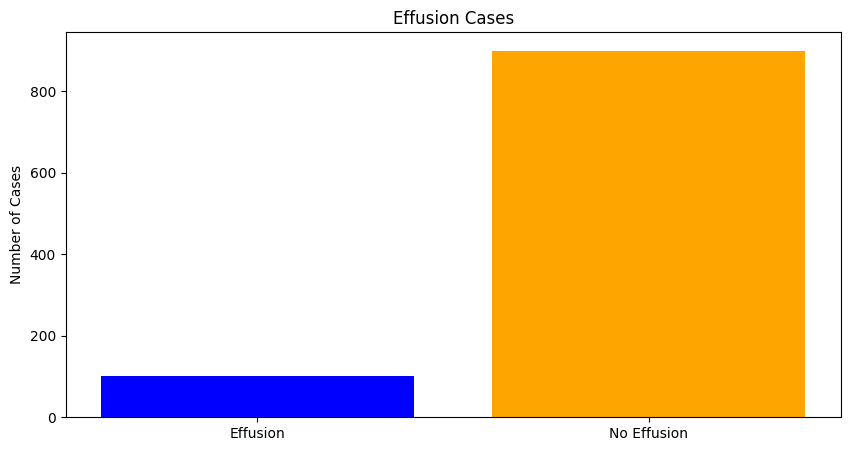

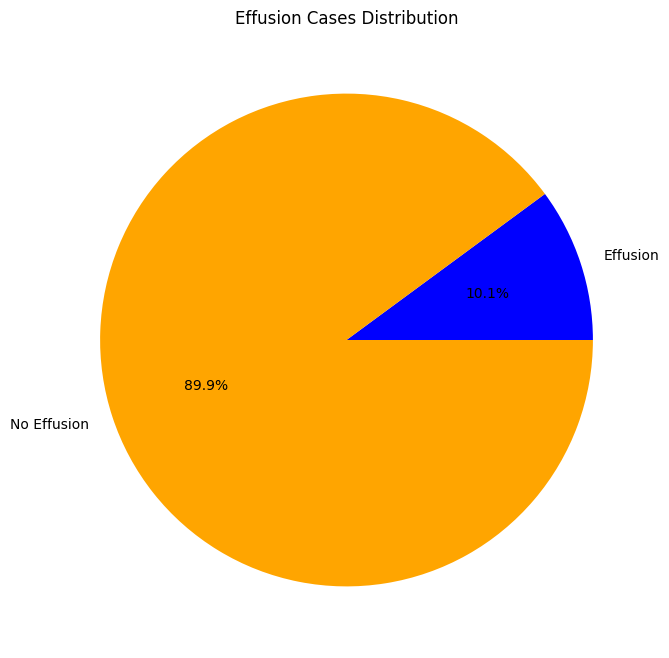

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named d2
# d2 = pd.read_csv('your_file.csv')  # If you need to read data from a file

# Calculate total cases and effusion cases
total_cases = len(d2)
effusion_cases = d2['Effusion'].sum()
effusion_percentage = (effusion_cases / total_cases) * 100

print(f"Percentage of Effusion Cases: {effusion_percentage:.2f}%")

# Plot data
# Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(['Effusion', 'No Effusion'], [effusion_cases, total_cases - effusion_cases], color=['blue', 'orange'])
plt.title('Effusion Cases')
plt.ylabel('Number of Cases')
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie([effusion_cases, total_cases - effusion_cases], labels=['Effusion', 'No Effusion'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Effusion Cases Distribution')
plt.show()


# Data Pre Processing

In [37]:
import cv2
import os
from multiprocessing import Pool, cpu_count

# Initialize training data list and set image size
training_data = []
IMG_SIZE = 64
dim = (IMG_SIZE, IMG_SIZE)

# Define the data directory and image files
data_dir = '/kaggle/input/data/'
imagefiles = ['images_001','images_002','images_003','images_004','images_005',
              'images_006','images_007','images_008','images_009','images_010',
              'images_011','images_012']

# Placeholder for process_image function definition
def process_image(pic_info):
    image_path, pic = pic_info
    if pic in training2:
        img_array = cv2.imread(os.path.join(image_path, pic), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, dim)
        label = d2[d2['Image Index'].str.contains(pic)].reset_index()['Effusion'][0]
        return [new_array, label]
    return None

# Function to create training data with multiprocessing
def create_training():
    pool = Pool(cpu_count())
    pic_infos = []
    for imagefile in imagefiles:
        image_path = os.path.join(data_dir, imagefile, 'images')
        pic_infos.extend([(image_path, pic) for pic in os.listdir(image_path)])
    
    results = pool.map(process_image, pic_infos)
    pool.close()
    pool.join()
    
    global training_data
    training_data = [result for result in results if result is not None]

# Call the function to create training data
create_training()

# Print the size of the training data to verify
print(f"Number of training samples: {len(training_data)}")


Number of training samples: 1000


In [112]:
print(len(training_data))

1000


In [113]:
random.shuffle(training_data)

In [114]:
X_eff = []
Y_eff = []

In [115]:
for features, label in training_data:
    X_eff.append(features)
    Y_eff.append(label)

X_eff = np.array(X_eff).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [116]:
pickle_out = open("X_eff.pickle","wb")
pickle.dump(X_eff, pickle_out)
pickle_out.close()

pickle_out = open("Y_eff.pickle","wb")
pickle.dump(Y_eff, pickle_out)
pickle_out.close()

In [117]:
X = pickle.load(open('X_eff.pickle','rb'))
Y = pickle.load(open('Y_eff.pickle','rb'))

In [118]:
X = X/255.0

In [119]:
X1 = np.asarray(X)
Y1 = np.asarray(Y)

In [46]:
# Function to plot images with labels
def plot_images(X, Y, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[i])
        plt.title(f'Label: {Y[i]}')
        plt.axis('off')
    plt.show()

# Simple Base Model

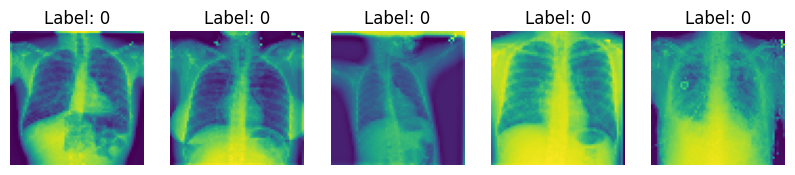

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


36/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7054 - loss: 0.6246

W0000 00:00:1716410663.883276   13372 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7365 - loss: 0.6052 - val_accuracy: 0.9750 - val_loss: 0.3185
Epoch 2/20
35/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8649 - loss: 0.4198

W0000 00:00:1716410664.398193   13370 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8718 - loss: 0.4070 - val_accuracy: 0.9750 - val_loss: 0.1851
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8879 - loss: 0.3482 - val_accuracy: 0.9750 - val_loss: 0.1589
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8884 - loss: 0.3490 - val_accuracy: 0.9750 - val_loss: 0.1621
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8898 - loss: 0.3442 - val_accuracy: 0.9750 - val_loss: 0.1615
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9072 - loss: 0.3084 - val_accuracy: 0.9750 - val_loss: 0.1625
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8881 - loss: 0.3533 - val_accuracy: 0.9750 - val_loss: 0.1620
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8913 - loss: 0.3458 - val_accuracy: 0.9750 - val_loss: 0.1598
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9056 - loss: 0.3100 - val_accuracy: 0.9750 - val_loss: 0.1642
Epo

W0000 00:00:1716410668.608181   13371 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.3620007336139679
Test Accuracy: 0.875
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Confusion Matrix:
[[175   0]
 [ 25   0]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      1.00      0.93       175
     Class 1       0.00      0.00      0.00        25

    accuracy                           0.88       200
   macro avg       0.44      0.50      0.47       200
weighted avg       0.77      0.88      0.82       200



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


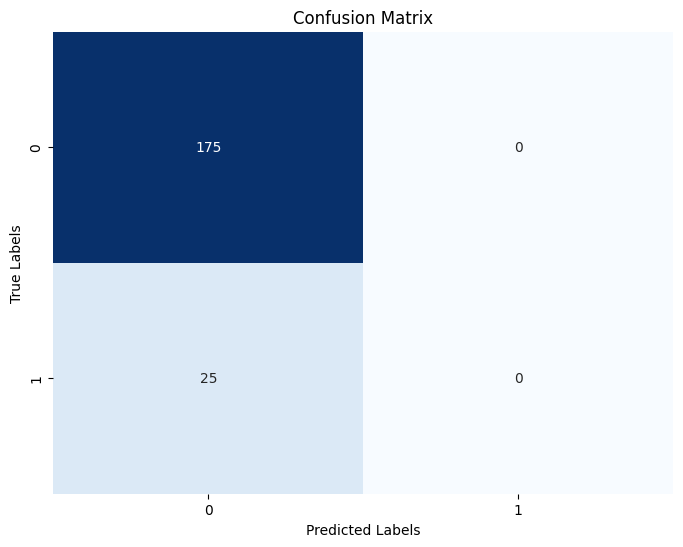

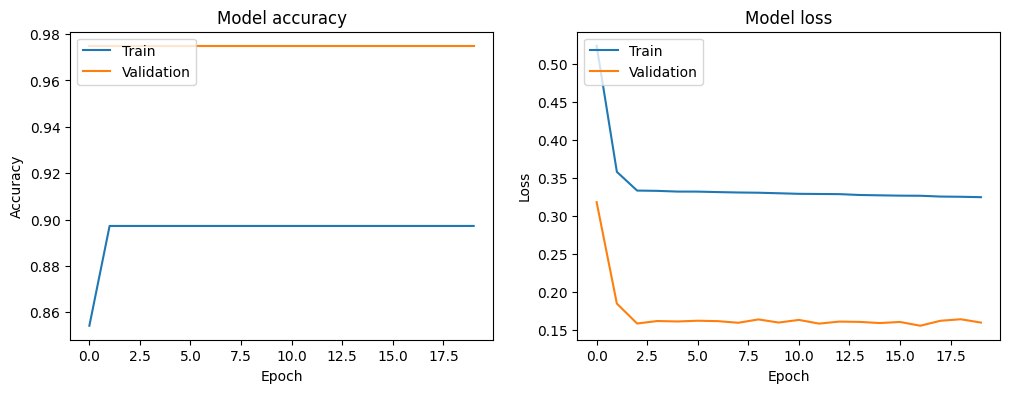

In [121]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)
plot_images(X_train,Y_train)
# Define the model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(64, (3,3), input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
model.add(Flatten())

# Dense layer 1
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Specify optimizer and compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, batch_size=16, epochs=20, validation_split=0.1)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
# Get model predictions
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

 #Plot confusion matrix
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


- as classification nreport shows high accuracy but there is fault in model as precision adn recall are to much low and have 0 valyues for class 1 which is not good so we ill improve our model with following techniques 

# Using class weight imbalance

Training class distribution: {0: 712, 1: 88}
Testing class distribution: {0: 187, 1: 13}
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.3572 - val_accuracy: 0.9500 - val_loss: 0.2275
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8853 - loss: 0.3406 - val_accuracy: 0.9500 - val_loss: 0.2267
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8768 - loss: 0.3515 - val_accuracy: 0.9500 - val_loss: 0.2237
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8989 - loss: 0.3097 - val_accuracy: 0.9500 - val_loss: 0.2313
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.3173 - val_accuracy: 0.9500 - val_loss: 0.2301
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8650 - loss: 0.3711 - val_accuracy: 0.9500 - val_loss: 0.2233
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8867 - loss: 0.3375 - val_accuracy: 0.9500 - val_loss: 0.2251
Epoch 8/10
45/45 ━━━━━━━━━━━━

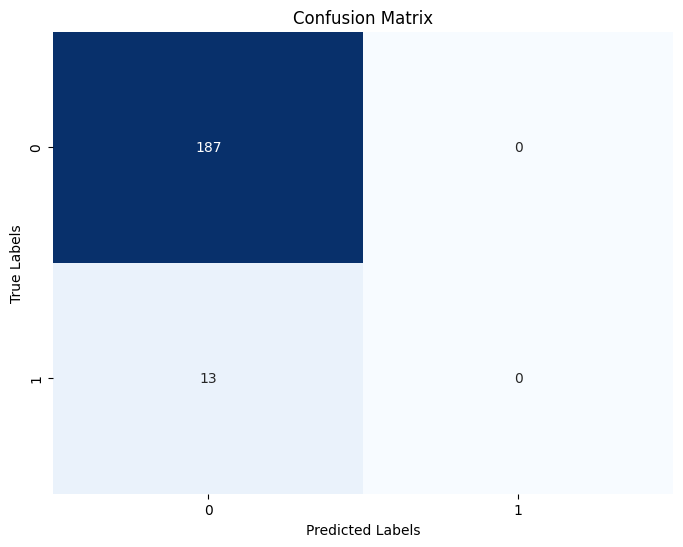

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97       187
     Class 1       0.00      0.00      0.00        13

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.87      0.94      0.90       200



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


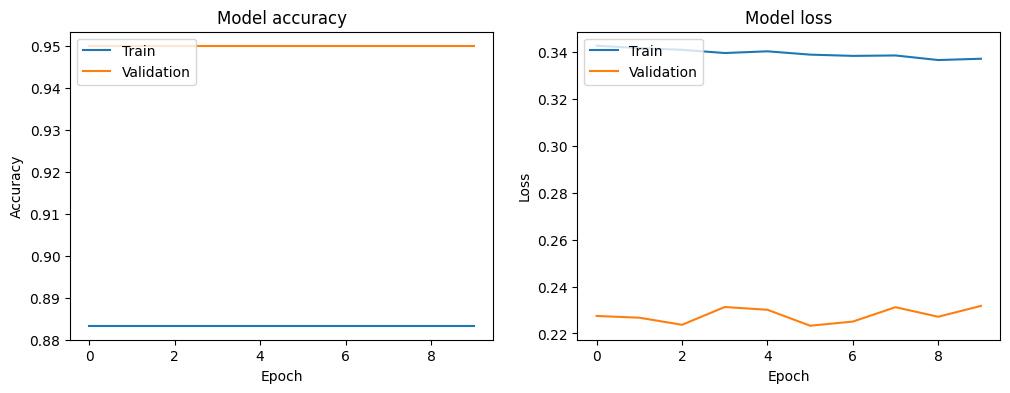

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Check class distribution
unique, counts = np.unique(Y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique, counts))}")

unique, counts = np.unique(Y_test, return_counts=True)
print(f"Testing class distribution: {dict(zip(unique, counts))}")

# Train the model
history = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)
#Plot confusion matrix
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Class Weights: {0: 0.5617977528089888, 1: 4.545454545454546}
Epoch 1/10
36/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8660 - loss: 0.8146

W0000 00:00:1716405427.721741   13371 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8178 - loss: 0.8076 - val_accuracy: 0.2125 - val_loss: 0.7577
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5999 - loss: 0.6491 - val_accuracy: 0.6750 - val_loss: 0.6287
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6004 - loss: 0.6758 - val_accuracy: 0.7750 - val_loss: 0.5983
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7811 - loss: 0.6464 - val_accuracy: 0.5875 - val_loss: 0.6681
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6854 - loss: 0.6994 - val_accuracy: 0.7000 - val_loss: 0.6159
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7023 - loss: 0.6908 - val_accuracy: 0.8000 - val_loss: 0.5706
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7547 - loss: 0.6746 - val_accuracy: 0.6500 - val_loss: 0.6440
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5999 - loss: 0.6757 - val_accuracy: 0.7875 - val_loss: 0.5659
Epo

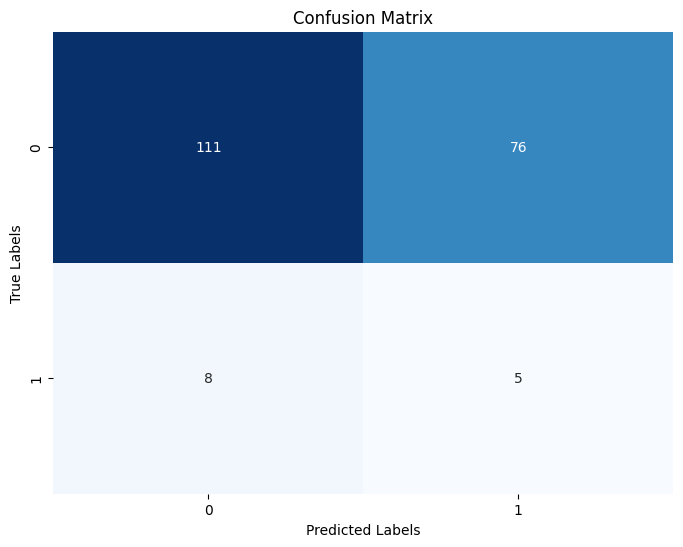

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.59      0.73       187
     Class 1       0.06      0.38      0.11        13

    accuracy                           0.58       200
   macro avg       0.50      0.49      0.42       200
weighted avg       0.88      0.58      0.69       200



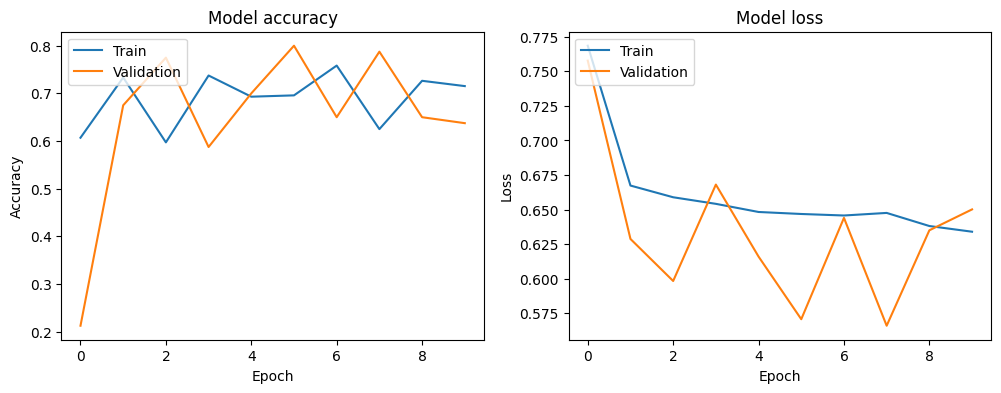

In [52]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

# Train the model with class weights
history = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1, class_weight=class_weights)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)
#Plot confusion matrix
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Epoch 1/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4319 - loss: 1.4157 - val_accuracy: 0.7375 - val_loss: 0.5667
Epoch 2/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6972 - loss: 1.2243 - val_accuracy: 0.4125 - val_loss: 0.7708
Epoch 3/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5940 - loss: 1.1359 - val_accuracy: 0.5000 - val_loss: 0.7456
Epoch 4/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5555 - loss: 1.2182 - val_accuracy: 0.5375 - val_loss: 0.7014
Epoch 5/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6255 - loss: 1.1619 - val_accuracy: 0.5125 - val_loss: 0.7310
Epoch 6/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6042 - loss: 1.1938 - val_accuracy: 0.5875 - val_loss: 0.6764
Epoch 7/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6211 - loss: 1.1710 - val_accuracy: 0.6625 - val_loss: 0.6179
Epoch 8/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6312 - loss: 1.1810 - val_accuracy: 0.

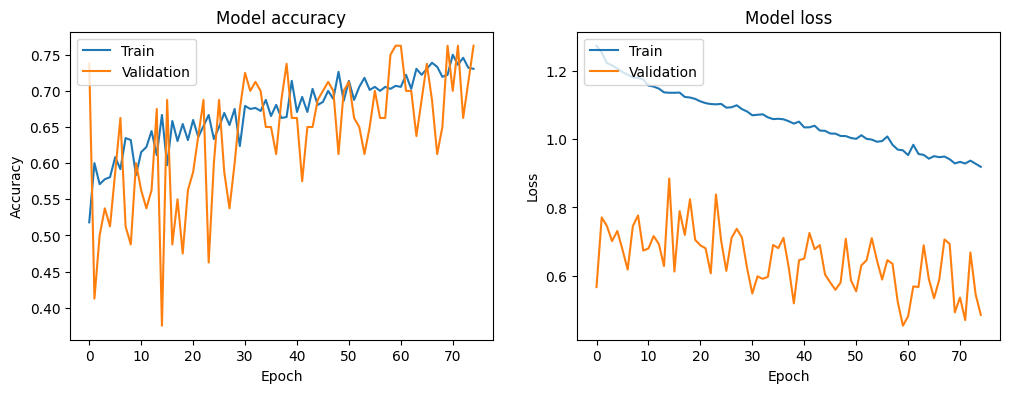

In [53]:
# Adjust class weights more significantly
class_weights = {0: 1.0, 1: 10.0}

# Train the model with the adjusted class weights
history = model.fit(X_train, Y_train, batch_size=4, epochs=75, validation_split=0.1, class_weight=class_weights)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Applying smote 

Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 0.0275
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9941 - loss: 0.0343 - val_accuracy: 1.0000 - val_loss: 0.0368
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 0.0187
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 0.0309
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0389 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0387 - val_accuracy: 1.0000 - val_loss: 0.0208
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 0.0238
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0319 - val_accuracy: 1.0000 - val_loss:

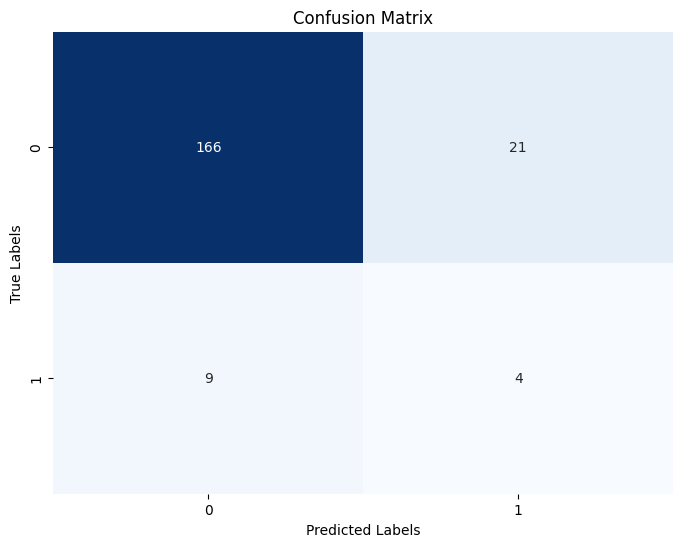

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.89      0.92       187
     Class 1       0.16      0.31      0.21        13

    accuracy                           0.85       200
   macro avg       0.55      0.60      0.56       200
weighted avg       0.90      0.85      0.87       200



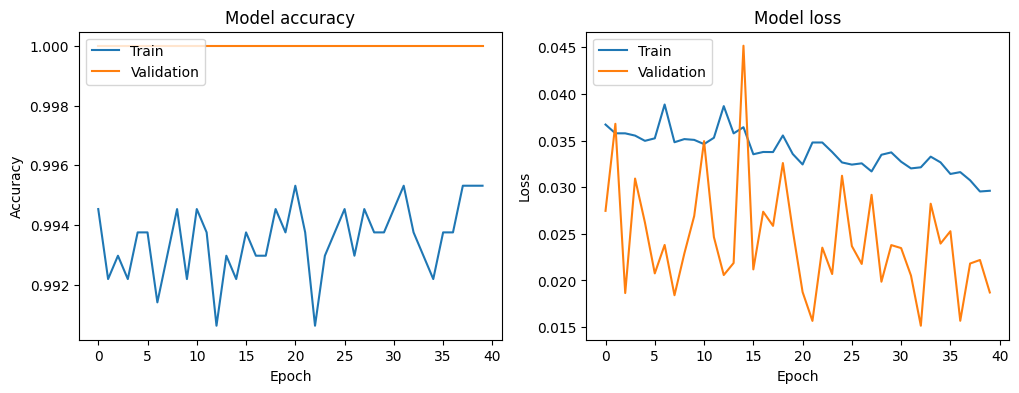

In [67]:
# smote
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Reshape data for SMOTE
X_train_flat = X_train.reshape((X_train.shape[0], -1))

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_flat, Y_train)

# Reshape data back to original shape
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# Train the model with resampled data
history = model.fit(X_train_resampled, Y_train_resampled, batch_size=16, epochs=40, validation_split=0.1)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

#Plot confusion matrix
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


- as you see after applying different tevchnique we fine tune our model and achieve  85 accuracy with precision adn recall value of 0.16,0.31 and 0.21 respectiuvely

# applying Restne50

In [122]:
# Convert grayscale images to RGB by repeating the single channel three times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Verify the new shape
print(f"New training data shape: {X_train_rgb.shape}")
print(f"New testing data shape: {X_test_rgb.shape}")


New training data shape: (800, 64, 64, 3)
New testing data shape: (200, 64, 64, 3)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8921 - loss: 0.7027 - val_accuracy: 0.9500 - val_loss: 0.5759
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8920 - loss: 0.6991 - val_accuracy: 0.9500 - val_loss: 0.6025
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8880 - loss: 0.7084 - val_accuracy: 0.9500 - val_loss: 0.6224
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8889 - loss: 0.7040 - val_accuracy: 0.9500 - val_loss: 0.6409
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8874 - loss: 0.7030 - val_accuracy: 0.9500 - val_loss: 0.6576
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8897 - loss: 0.6782 - val_accuracy: 0.9125 - val_loss: 0.6686
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7973 - loss: 0.7490 - val_accuracy: 0.7125 - val_loss: 0.6824
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6806 - loss: 0.7546 - val_accuracy: 0.5375 - 

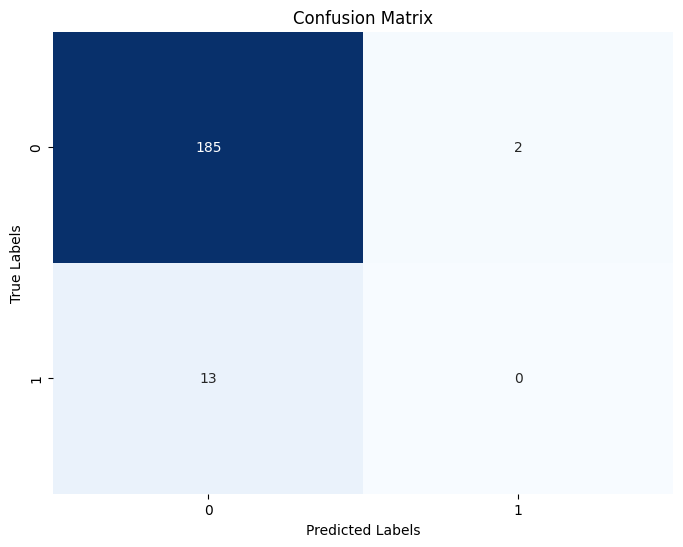

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96       187
     Class 1       0.00      0.00      0.00        13

    accuracy                           0.93       200
   macro avg       0.47      0.49      0.48       200
weighted avg       0.87      0.93      0.90       200



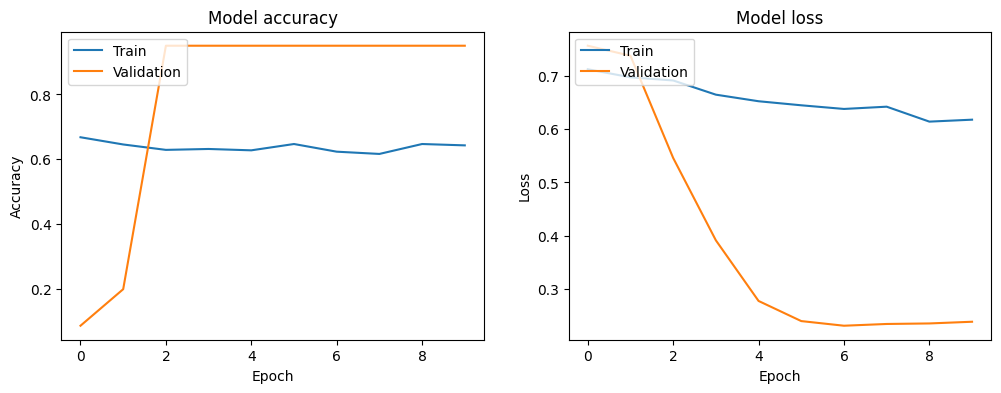

In [74]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# Convert grayscale images to RGB by repeating the single channel three times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train_rgb.shape[1:])

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X_train_rgb, Y_train, batch_size=16, epochs=20, validation_split=0.1, class_weight=class_weights)

# Unfreeze some of the layers in the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with the unfrozen layers
history = model.fit(X_train_rgb, Y_train, batch_size=16, epochs=10, validation_split=0.1, class_weight=class_weights)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test_rgb, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (model.predict(X_test_rgb) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)
#Plot confusion matrix
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


- as again accuracy is high but f1score,precison and recall have 0 value that means our model is not goo din predicting the 1 class which is not good sign let tuhe this to  improve overall performance of our model 

## By Adjusting threshold

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9330 - loss: 0.2205
Test Loss: 0.24341928958892822
Test Accuracy: 0.925000011920929
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix:
[[185   2]
 [ 13   0]]


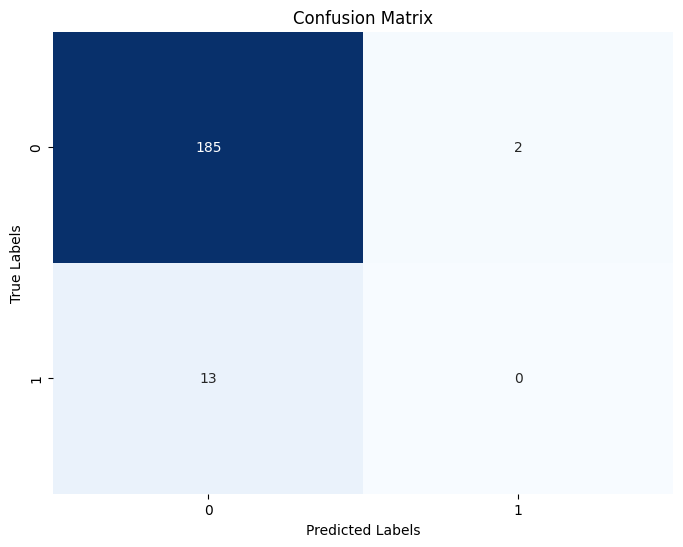

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96       187
     Class 1       0.00      0.00      0.00        13

    accuracy                           0.93       200
   macro avg       0.47      0.49      0.48       200
weighted avg       0.87      0.93      0.90       200



/tmp/ipykernel_13181/4183844656.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


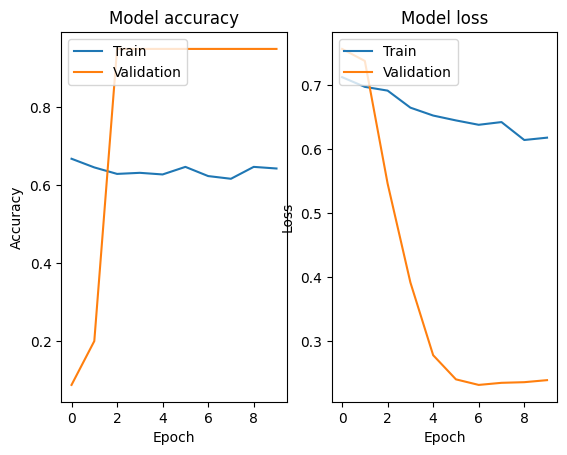

In [75]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test_rgb, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get model predictions with adjusted threshold
threshold = 0.3  # Adjust this value to find the optimal threshold
Y_pred_prob = model.predict(X_test_rgb)
Y_pred = (Y_pred_prob > threshold).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)
#Plot confusion matrix
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


- as by adjusting threshold our model achieve 93 accuracy and significancenumber in precison recall and f1score

In [71]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-s5vmgum5
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-s5vmgum5
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.8101 - loss: 0.0660 - val_accuracy: 0.9500 - val_loss: 0.0463
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8892 - loss: 0.0323 - val_accuracy: 0.9500 - val_loss: 0.0340
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8830 - loss: 0.0281 - val_accuracy: 0.9500 - val_loss: 0.0253
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8985 - loss: 0.0230 - val_accuracy: 0.9500 - val_loss: 0.0245
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8818 - loss: 0.0230 - val_accuracy: 0.9500 - val_loss: 0.0237
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9058 - loss: 0.0222 - val_accuracy: 0.9625 - val_loss: 0.0239
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9091 - loss: 0.0173 - val_accuracy: 0.9625 - val_loss: 0.0260
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9253 - loss: 0.0187 - val_accuracy: 0.9625 -

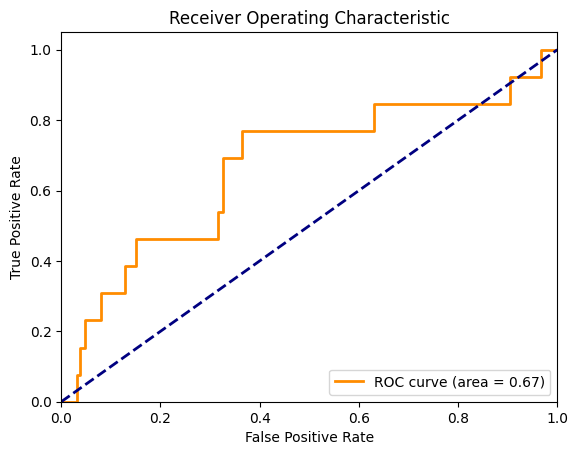

In [78]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = - alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed

# Re-compile the model with focal loss
model.compile(optimizer=Adam(learning_rate=0.00001), loss=focal_loss(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train_rgb, Y_train, batch_size=16, epochs=20, validation_split=0.1, class_weight=class_weights)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test_rgb, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get model predictions with the adjusted threshold
threshold = 0.5  # Reset to default for initial evaluation
Y_pred_prob = model.predict(X_test_rgb)
Y_pred = (Y_pred_prob > threshold).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


- as you see the acccuracy is high but f1score, recal and other value are 0 so we have to improve this

# Applying resnet0n Densenet121 together 

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8876 - loss: 0.0489 - val_accuracy: 0.9500 - val_loss: 0.0337
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8688 - loss: 0.0463 - val_accuracy: 0.9500 - val_loss: 0.0277
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8909 - loss: 0.0379 - val_accuracy: 0.9500 - val_loss: 0.0249
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8805 - loss: 0.0406 - val_accuracy: 0.9500 - val_loss: 0.0238
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8979 - loss: 0.0348 - val_accuracy: 0.9500 - val_loss: 0.0232
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8756 - loss: 0.0430 - val_accuracy: 0.9500 - val_loss: 0.0229
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8621 - loss: 0.0472 - val_accuracy: 0.9500 - val_loss: 0.0225
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8952 - loss: 0.0366 - val_accuracy: 0.9500 - 

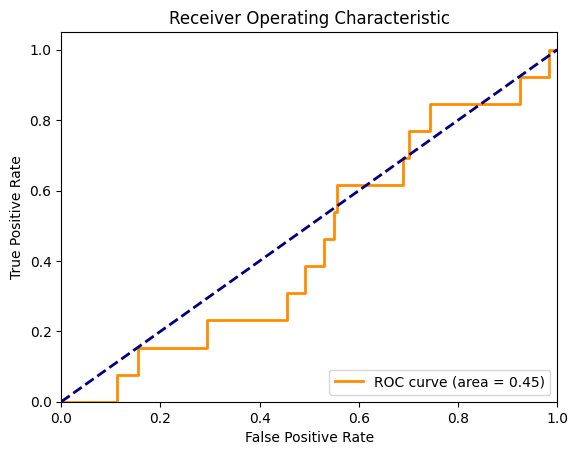

In [80]:
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define a function to create a model
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

# Create models
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=X_train_rgb.shape[1:])
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=X_train_rgb.shape[1:])

model_resnet = create_model(base_model_resnet)
model_densenet = create_model(base_model_densenet)

# Compile models
model_resnet.compile(optimizer=Adam(learning_rate=0.00001), loss=focal_loss(), metrics=['accuracy'])
model_densenet.compile(optimizer=Adam(learning_rate=0.00001), loss=focal_loss(), metrics=['accuracy'])

# Train models
history_resnet = model_resnet.fit(X_train_rgb, Y_train, batch_size=16, epochs=20, validation_split=0.1, class_weight=class_weights)
history_densenet = model_densenet.fit(X_train_rgb, Y_train, batch_size=16, epochs=20, validation_split=0.1, class_weight=class_weights)

# Evaluate models
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test_rgb, Y_test)
loss_densenet, accuracy_densenet = model_densenet.evaluate(X_test_rgb, Y_test)
print("ResNet Test Loss:", loss_resnet)
print("ResNet Test Accuracy:", accuracy_resnet)
print("DenseNet Test Loss:", loss_densenet)
print("DenseNet Test Accuracy:", accuracy_densenet)

# Get model predictions
threshold = 0.5
Y_pred_prob_resnet = model_resnet.predict(X_test_rgb)
Y_pred_prob_densenet = model_densenet.predict(X_test_rgb)

# Ensemble Voting
Y_pred_prob_avg = (Y_pred_prob_resnet + Y_pred_prob_densenet) / 2
Y_pred_ensemble = (Y_pred_prob_avg > threshold).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred_ensemble)
print("Confusion Matrix:")
print(cm)

# Print classification report
cr = classification_report(Y_test, Y_pred_ensemble, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot ROC Curve for ensemble
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob_avg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


- as shown above dense net adnrestnet give hogh accuracy of 93.

In [87]:
# applying ALexnet

# AlexNet Model Implimentation

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# Define AlexNet architecture
def create_alexnet(input_shape):
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Convert grayscale images to RGB by repeating the single channel three times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Create AlexNet model
alexnet = create_alexnet(X_train_rgb.shape[1:])

# Compile the model
alexnet.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history_alexnet = alexnet.fit(X_train_rgb, Y_train, batch_size=8, epochs=10, validation_split=0.1, class_weight=class_weights)

# Evaluate the model on the testing set
loss, accuracy = alexnet.evaluate(X_test_rgb, Y_test)
print("AlexNet Test Loss:", loss)
print("AlexNet Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (alexnet.predict(X_test_rgb) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'])
plt.plot(history_alexnet.history['val_accuracy'])
plt.title('AlexNet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'])
plt.plot(history_alexnet.history['val_loss'])
plt.title('AlexNet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_26_1/max_pooling2d_83_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 2, 2, 1]](sequential_26_1/conv2d_157_1/Relu)' with input shapes: [8,2,2,256].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(8, 2, 2, 256), dtype=float32)

Epoch 1/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.2508 - loss: 0.8356 - val_accuracy: 0.9750 - val_loss: 0.5673
Epoch 2/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8628 - loss: 0.7156 - val_accuracy: 0.8500 - val_loss: 0.6856
Epoch 3/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5673 - loss: 0.7128 - val_accuracy: 0.0250 - val_loss: 0.7262
Epoch 4/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1738 - loss: 0.7620 - val_accuracy: 0.9625 - val_loss: 0.6700
Epoch 5/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6509 - loss: 0.6994 - val_accuracy: 0.0250 - val_loss: 0.7346
Epoch 6/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3232 - loss: 0.7437 - val_accuracy: 0.0500 - val_loss: 0.7223
Epoch 7/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5939 - loss: 0.6533 - val_accuracy: 0.0250 - val_loss: 0.8294
Epoch 8/80
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2624 - loss: 0.7119 - val_accuracy: 0.8000 - 

W0000 00:00:1716410994.225050   13373 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7763 - loss: 0.9130
AlexNet Test Loss: 0.935349702835083
AlexNet Test Accuracy: 0.8100000023841858
1/7 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step

W0000 00:00:1716410995.601309   13373 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Confusion Matrix:
[[157  18]
 [ 20   5]]


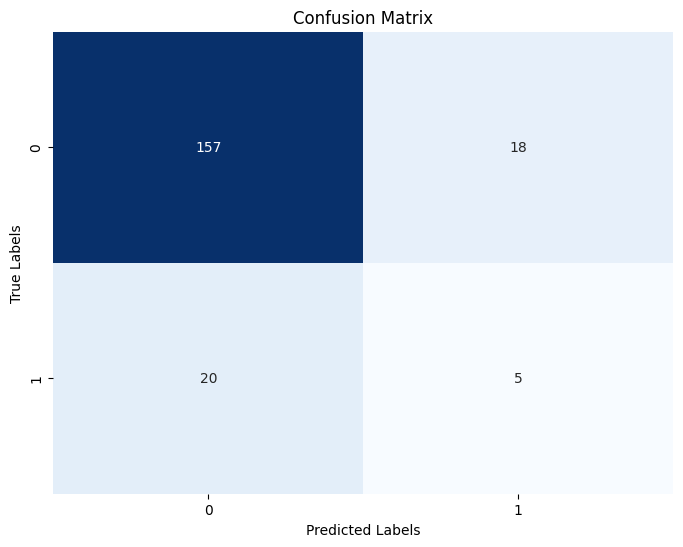

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.90      0.89       175
     Class 1       0.22      0.20      0.21        25

    accuracy                           0.81       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.80      0.81      0.81       200



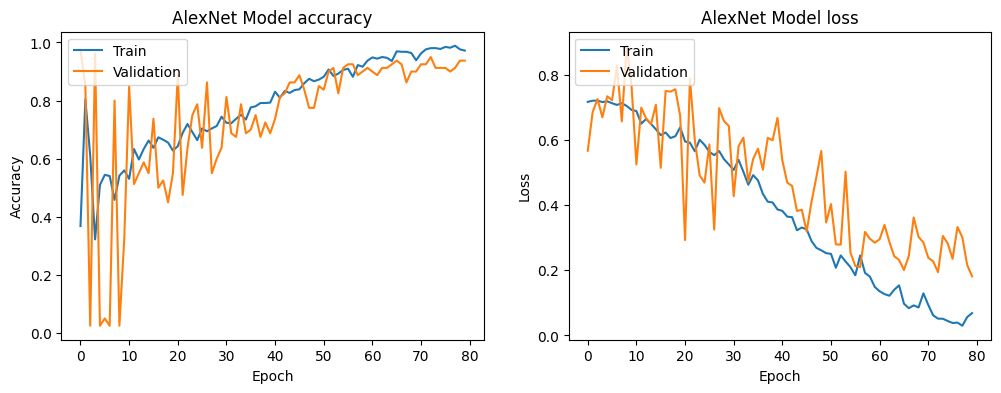

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define AlexNet architecture
def create_alexnet(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(96, (11, 11), strides=4, activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Assuming X_train and X_test are your datasets
# Resize your images to a larger size
X_train_resized = tf.image.resize(X_train, (227, 227))
X_test_resized = tf.image.resize(X_test, (227, 227))

# Convert grayscale images to RGB by repeating the single channel three times
X_train_rgb = np.repeat(X_train_resized, 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized, 3, axis=-1)

# Create AlexNet model
alexnet = create_alexnet(X_train_rgb.shape[1:])

# Compile the model
alexnet.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history_alexnet = alexnet.fit(X_train_rgb, Y_train, batch_size=8, epochs=80, validation_split=0.1, class_weight=class_weights)

# Evaluate the model on the testing set
loss, accuracy = alexnet.evaluate(X_test_rgb, Y_test)
print("AlexNet Test Loss:", loss)
print("AlexNet Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (alexnet.predict(X_test_rgb) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'])
plt.plot(history_alexnet.history['val_accuracy'])
plt.title('AlexNet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'])
plt.plot(history_alexnet.history['val_loss'])
plt.title('AlexNet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


> as alex net gives 81 accuracy with model implimentation

# Darknet 19 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20


2024-05-22 20:37:58.742434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4159: 3.01073, expected 2.5738
2024-05-22 20:37:58.742513: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8128: 2.8459, expected 2.40896
2024-05-22 20:37:58.742592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24576: 4.16104, expected 3.42136
2024-05-22 20:37:58.742600: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24577: 4.70115, expected 3.96148
2024-05-22 20:37:58.742608: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24578: 5.73271, expected 4.99304
2024-05-22 20:37:58.742615: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24579: 4.78807, expected 4.04839
2024-05-22 20:37:58.742622: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24581: 5.81591, expected 5.07623
2024-05-22 20:37:58.742630: E e

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.6656 - loss: 0.8938 - val_accuracy: 0.9500 - val_loss: 0.6484
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7208 - loss: 0.5446 - val_accuracy: 0.9500 - val_loss: 0.5744
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7416 - loss: 0.4995 - val_accuracy: 0.9500 - val_loss: 0.5159
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8930 - loss: 0.3183 - val_accuracy: 0.9500 - val_loss: 0.4508
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9028 - loss: 0.2581 - val_accuracy: 0.9500 - val_loss: 0.3689
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9265 - loss: 0.2050 - val_accuracy: 0.9500 - val_loss: 0.3347
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9297 - loss: 0.2185 - val_accuracy: 0.9500 - val_loss: 0.2511
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9544 - loss: 0.0992 - val_accuracy: 0.9500 - val_loss: 0

2024-05-22 20:38:29.004604: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.74267, expected 2.93226
2024-05-22 20:38:29.004673: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.81792, expected 3.00751
2024-05-22 20:38:29.004682: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.10301, expected 4.2926
2024-05-22 20:38:29.004690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.26842, expected 3.45801
2024-05-22 20:38:29.004697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.07757, expected 4.26716
2024-05-22 20:38:29.004705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.13438, expected 4.32397
2024-05-22 20:38:29.004712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.00142, expected 5.191
2024-05-22 20:38:29.004731: E external/local_xla/xla/servi

1/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8750 - loss: 0.3295

W0000 00:00:1716410310.447578   13373 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-22 20:38:30.655465: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.40412, expected 2.01423
2024-05-22 20:38:30.655530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 575: 2.82112, expected 2.43123
2024-05-22 20:38:30.655566: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4032: 2.65152, expected 2.26163
2024-05-22 20:38:30.655578: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4095: 2.4438, expected 2.05391
2024-05-22 20:38:30.655617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8192: 3.06016, expected 2.26478
2024-05-22 20:38:30.655627: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8193: 5.28521, expected 4.48984
2024-05-22 20:38:30.655636: E external/local_xla/xl

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.8608 - loss: 0.4219
Darknet-19 Test Loss: 0.4563528299331665
Darknet-19 Test Accuracy: 0.8450000286102295
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step
Confusion Matrix:
[[166  21]
 [ 10   3]]


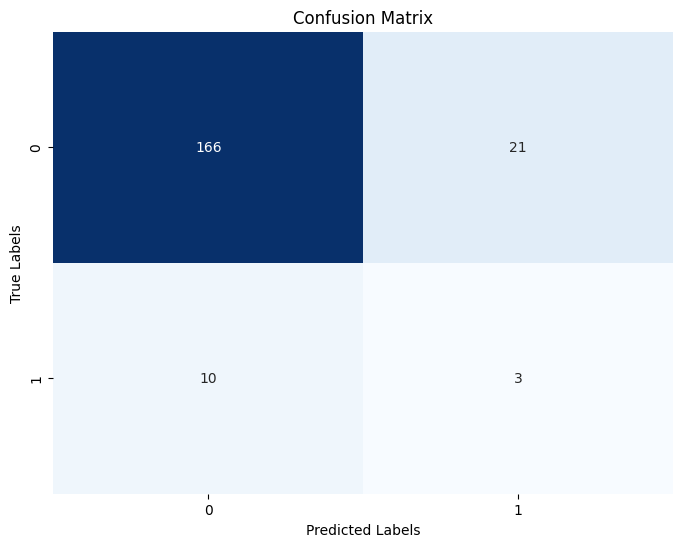

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.89      0.91       187
     Class 1       0.12      0.23      0.16        13

    accuracy                           0.84       200
   macro avg       0.53      0.56      0.54       200
weighted avg       0.89      0.84      0.87       200



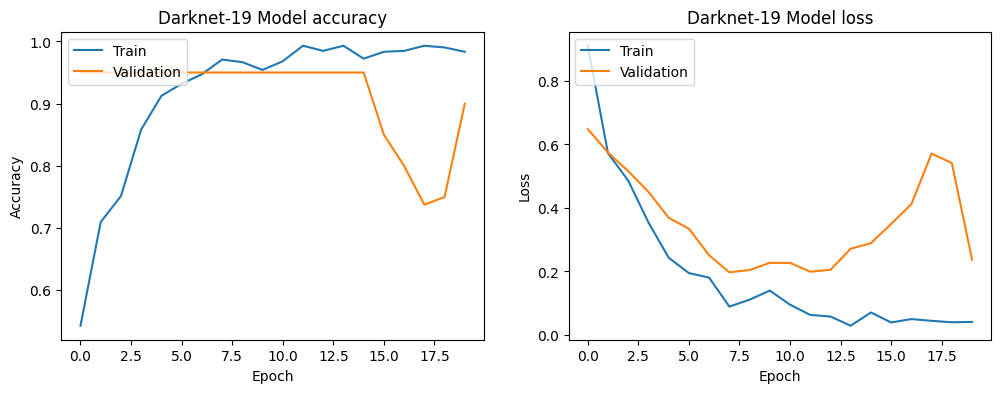

In [107]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define Darknet-19 architecture
def create_darknet19(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(64, (1, 1), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(128, (1, 1), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(256, (1, 1), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(256, (1, 1), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(1024, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(512, (1, 1), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(1024, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(512, (1, 1), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(1024, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),

        Flatten(),
        Dense(1000, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Convert grayscale images to RGB by repeating the single channel three times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Create Darknet-19 model
darknet19 = create_darknet19(X_train_rgb.shape[1:])

# Compile the model
darknet19.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history_darknet19 = darknet19.fit(X_train_rgb, Y_train, batch_size=16, epochs=20, validation_split=0.1, class_weight=class_weights)

# Evaluate the model on the testing set
loss, accuracy = darknet19.evaluate(X_test_rgb, Y_test)
print("Darknet-19 Test Loss:", loss)
print("Darknet-19 Test Accuracy:", accuracy)

# Get model predictions
Y_pred = (darknet19.predict(X_test_rgb) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
cr = classification_report(Y_test, Y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(cr)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_darknet19.history['accuracy'])
plt.plot(history_darknet19.history['val_accuracy'])
plt.title('Darknet-19 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_darknet19.history['loss'])
plt.plot(history_darknet19.history['val_loss'])
plt.title('Darknet-19 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
